In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy

import k3d
import yaml
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
import json
import pymesh

import torch

import trimesh.transformations as tt
import trimesh
from io import BytesIO

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-k6erp7m1 because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
import os
os.environ['OMP_NUM_THREADS'] = '8'

In [4]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = 1.0

            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [5]:
# mm/pixel
HIGH_RES = 0.02
MED_RES = 0.05
LOW_RES = 0.125
XLOW_RES = 0.25

## 1. Working with point patches

In [6]:
from sharpf.data import DataGenerationException
from sharpf.utils.abc_utils.abc.abc_data import ABCModality, ABCChunk, ABC_7Z_FILEMASK
from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.data.camera_pose_manager import POSE_MANAGER_BY_TYPE
from sharpf.data.datasets.sharpf_io import save_depth_maps
from sharpf.data.imaging import IMAGING_BY_TYPE
from sharpf.data.noisers import NOISE_BY_TYPE
from sharpf.utils.abc_utils.abc import feature_utils
from sharpf.utils.py_utils.console import eprint_t
from sharpf.utils.py_utils.os import add_suffix
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.utils.abc_utils.mesh.io import trimesh_load
from sharpf.utils.plotting import display_depth_sharpness
from sharpf.utils.camera_utils.camera_pose import camera_to_display
from sharpf.utils.abc_utils.mesh.indexing import reindex_zerobased, compute_relative_indexes
import sharpf.data.data_smells as smells

In [10]:
!ls /data/abc/sharp_features_whole_models/CT

blade.ply	     mesh_scan_alignment_nozel	zeiss.obj
mesh_scan_alignment  mesh_scan_alignment_tube


In [476]:
filename = '/data/abc/sharp_features_whole_models/CT/mesh_scan_alignment/flywheel.obj'
mesh = trimesh.load(filename)

In [477]:
print(np.max(mesh.bounding_box.extents))

1.3977271199999999


In [549]:
config = {
  "shape_fabrication_extent": 10.0,
  "short_curve_quantile": 0.25,
  "base_n_points_per_short_curve": 8,
  "base_resolution_3d": 0.125,
  "camera_pose": {
    "type": "composite",
    "sequences": [
      {
        "type": "sphere_to_origin",
        "n_images": 18
      }
    ]
  },
  "imaging": {
    "type": "raycasting",
    "projection": "ortho",
    "resolution_image": 2048,
    "resolution_3d": 0.02,
    "fov": [115, 85, 80],
    "validate_image": True
  },
  "noise": {
    "type": "z_direction",
    "scale": 0.0
  },
  "annotation": {
    "type": "surface_based_aabb",
    "distance_upper_bound": 1.0
  },
  "smell_coarse_surfaces_by_num_edges": {
    "num_edges_threshold": 8
  },
  "smell_coarse_surfaces_by_angles": {
    "max_angle_threshold_degrees": 10.0
  },
  "smell_deviating_resolution": {
    "resolution_3d": 0.02,
    "resolution_deviation_tolerance": 0.01
  },
  "smell_sharpness_discontinuities": { },
  "smell_bad_face_sampling": {
    "min_points_per_face": 0.02,
    "max_points_per_face": 20.0
  },
  "smell_raycasting_background": { },
  "smell_mesh_self_intersections": { },
  "smell_depth_discontinuity": {
    "depth_discontinuity_threshold": 0.5
  }
}

In [550]:
shape_fabrication_extent = config.get('shape_fabrication_extent', 10.0)
base_n_points_per_short_curve = config.get('base_n_points_per_short_curve', 8)
base_resolution_3d = config.get('base_resolution_3d', LOW_RES)

short_curve_quantile = config.get('short_curve_quantile', 0.05)

pose_manager = load_func_from_config(POSE_MANAGER_BY_TYPE, config['camera_pose'])
imaging = load_func_from_config(IMAGING_BY_TYPE, config['imaging'])
noiser = load_func_from_config(NOISE_BY_TYPE, config['noise'])
annotator = load_func_from_config(ANNOTATOR_BY_TYPE, config['annotation'])

In [551]:
smell_coarse_surfaces_by_num_edges = smells.SmellCoarseSurfacesByNumEdges.from_config(config['smell_coarse_surfaces_by_num_edges'])
smell_coarse_surfaces_by_angles = smells.SmellCoarseSurfacesByAngles.from_config(config['smell_coarse_surfaces_by_angles'])
smell_deviating_resolution = smells.SmellDeviatingResolution.from_config(config['smell_deviating_resolution'])
smell_sharpness_discontinuities = smells.SmellSharpnessDiscontinuities.from_config(config['smell_sharpness_discontinuities'])
smell_bad_face_sampling = smells.SmellBadFaceSampling.from_config(config['smell_bad_face_sampling'])
smell_raycasting_background = smells.SmellRaycastingBackground.from_config(config['smell_raycasting_background'])
smell_depth_discontinuity = smells.SmellDepthDiscontinuity.from_config(config['smell_depth_discontinuity'])
smell_mesh_self_intersections = smells.SmellMeshSelfIntersections.from_config(config['smell_mesh_self_intersections'])


In [552]:
def scale_mesh(
    mesh, 
    resolution_3d,
    n_points_per_edge=1):
    
    avg_edge_len = np.linalg.norm(
        mesh.vertices[mesh.edges_unique][:, 0, :] - 
        mesh.vertices[mesh.edges_unique][:, 1, :],
        axis=1).mean()

    least_len_mm = resolution_3d * n_points_per_edge

    scale = least_len_mm / avg_edge_len
    mesh = mesh.apply_scale(scale)

    return mesh, scale


In [554]:
mesh, mesh_scale = scale_mesh(
    mesh,
    base_resolution_3d,
    n_points_per_edge=0.8)

mesh = mesh.apply_translation(-mesh.vertices.mean(axis=0))

In [555]:
print(np.max(mesh.bounding_box.extents))

19.883163813104204


In [556]:
np.linalg.norm(
        mesh.vertices[mesh.edges_unique][:, 0, :] - 
        mesh.vertices[mesh.edges_unique][:, 1, :],
        axis=1).mean()

0.10000000000000003

In [557]:
display_sharpness(
    mesh, plot_meshvert=False, meshvert_psize=0.1,
)

Output()

In [558]:
point_patches = []

In [559]:
# generate camera poses
pose_manager.prepare(mesh)
pose_manager_iter = iter(pose_manager)

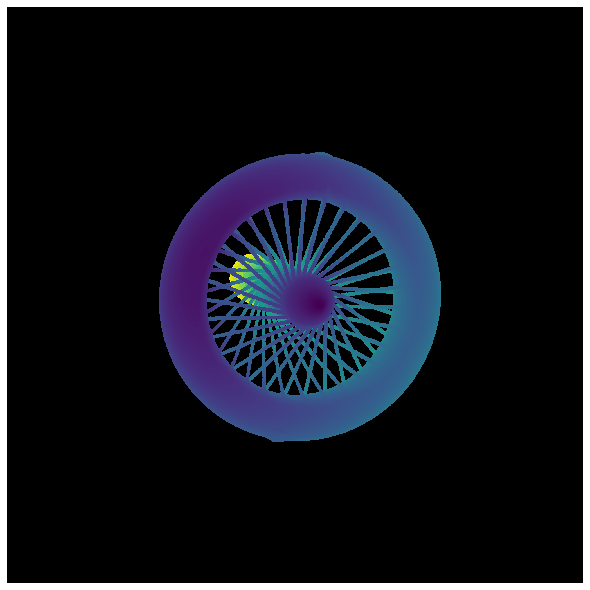

In [562]:
camera_pose = next(pose_manager_iter)

# extract neighbourhood
try:
    image, points, normals, mesh_face_indexes = \
        imaging.get_image_from_pose(mesh, camera_pose, return_hit_face_indexes=True)
except DataGenerationException as e:
    eprint_t(str(e))
    
display_depth_sharpness(
    depth_images=[camera_to_display(image)]
)

In [563]:
display_sharpness(
    None, plot_meshvert=True, meshvert_psize=imaging.resolution_3d / 2,
#     sharp_vert=camera_pose.camera_to_world(imaging.rays_origins), sharpvert_psize=0.5,
#     sharp_vert=nbhood_sharp_vert, sharpvert_psize=0.2,
    samples=camera_pose.camera_to_world(imaging.image_to_points(image)), samples_psize=0.02,
)

Output()

In [524]:
# # convert everything to images
# ray_indexes = np.where(image.ravel() != 0)[0]
# noisy_image = image
# normals = imaging.points_to_image(normals, ray_indexes, assign_channels=[0, 1, 2])

In [564]:
point_patches = []

# generate camera poses
pose_manager.prepare(mesh)
for camera_pose in tqdm(pose_manager):

    # extract neighbourhood
    try:
        image, points, normals, mesh_face_indexes = \
            imaging.get_image_from_pose(mesh, camera_pose, return_hit_face_indexes=True)
    except DataGenerationException as e:
        eprint_t(str(e))
        
    mesh_vertex_indexes = np.unique(mesh.faces[mesh_face_indexes])

    # convert everything to images
    ray_indexes = np.where(image.ravel() != 0)[0]
    noisy_image = image
    normals = imaging.points_to_image(normals, ray_indexes, assign_channels=[0, 1, 2])

    patch_info = {
        'image': noisy_image,
        'normals': normals,
        'item_id': os.path.basename(filename),
        'orig_vert_indices': mesh_vertex_indexes,
        'orig_face_indexes': mesh_face_indexes,
        'camera_pose': camera_pose.camera_to_world_4x4,
        'mesh_scale': mesh_scale
    }
    
    point_patches.append(patch_info)

18it [00:40,  2.25s/it]


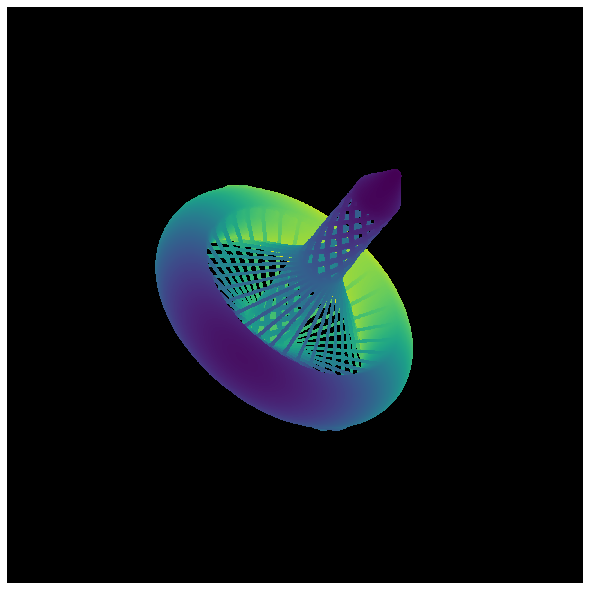

In [565]:
display_depth_sharpness(
    depth_images=[camera_to_display(point_patches[17]['image'])]
)

In [566]:
from functools import partial
import h5py
import sharpf.utils.abc_utils.hdf5.io_struct as io

UnlabeledDepthMapIO = io.HDF5IO({
        'image': io.Float64('image'),
        'normals': io.Float64('normals'),
        'item_id': io.AsciiString('item_id'),
        'orig_vert_indices': io.VarInt32('orig_vert_indices'),
        'orig_face_indexes': io.VarInt32('orig_face_indexes'),
        'camera_pose': io.Float64('camera_pose'),
        'mesh_scale': io.Float64('mesh_scale'),
    },
    len_label='has_sharp',
    compression='lzf')


def save_depth_maps(patches, filename):
    # turn a list of dicts into a dict of torch tensors:
    # default_collate([{'a': 'str1', 'x': np.random.normal()}, {'a': 'str2', 'x': np.random.normal()}])
    # Out[26]: {'a': ['str1', 'str2'], 'x': tensor([0.4252, 0.1414], dtype=torch.float64)}
    collate_fn = partial(io.collate_mapping_with_io, io=UnlabeledDepthMapIO)
    patches = collate_fn(patches)

    with h5py.File(filename, 'w') as f:
        for key in ['image', 'normals']:
            UnlabeledDepthMapIO.write(f, key, patches[key].numpy())
        UnlabeledDepthMapIO.write(f, 'item_id', patches['item_id'])
        UnlabeledDepthMapIO.write(f, 'orig_vert_indices', patches['orig_vert_indices'])
        UnlabeledDepthMapIO.write(f, 'orig_face_indexes', patches['orig_face_indexes'])
        UnlabeledDepthMapIO.write(f, 'camera_pose', patches['camera_pose'].numpy())
        UnlabeledDepthMapIO.write(f, 'mesh_scale', patches['mesh_scale'].numpy())

In [567]:
save_depth_maps(point_patches, '/logs/whole_images/{name}__{size:3.1f}mm.hdf5'.format(
    name=os.path.basename(filename),
    size=np.max(mesh.bounding_box.extents)
))